In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**Please write your name below**

In [0]:
#Audrey Bovet

# Iris dataset

We will use the Iris dataset (from Lab 1) again.

In [3]:
from sklearn import datasets
iris_dataset = datasets.load_iris()

In [4]:
X_iris, y_iris = iris_dataset.data, iris_dataset.target
print(X_iris.shape, y_iris.shape)

(150, 4) (150,)


In [5]:
from matplotlib.colors import ListedColormap
# colormap = ListedColormap(['blue', 'red', 'green'])
colormap = ListedColormap(['red', 'green', 'blue'])

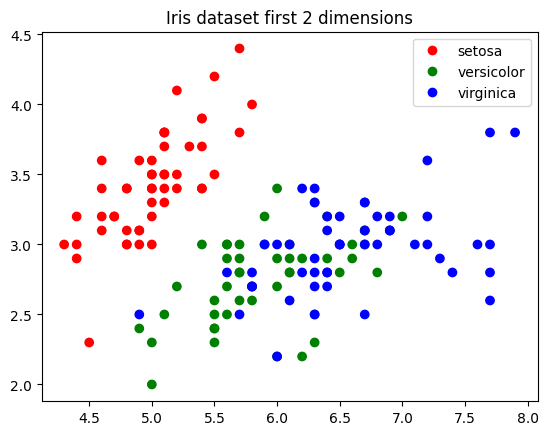

In [6]:
scatter = plt.scatter(X_iris[:,0], X_iris[:,1], c=y_iris, cmap=colormap)
plt.legend(scatter.legend_elements()[0], iris_dataset.target_names)
plt.title("Iris dataset first 2 dimensions")
plt.show()

# 2D GMM

Let us work only on the first two dimensions of the dataset for now.

In [7]:
# We keep only the first 2 dimensions of X_iris
X_iris_2d = X_iris[:, :2]

## Basic GMM

**Fit a Gaussian Mixture Model (gmm) on the first 2 dimensions of the dataset**

No need to re-implement GMM yourself, use scikit-learn.

In [25]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=0).fit(X_iris_2d)

**Display the mean vector and covariance matrix of each cluster**

In [26]:
gmm.means_
gmm.covariances_


array([[[0.27671149, 0.08897036],
        [0.08897036, 0.09389206]],

       [[0.36153508, 0.05159664],
        [0.05159664, 0.08927917]],

       [[0.11944714, 0.08835648],
        [0.08835648, 0.11893388]]])

Now let us try to visualize the result.

We will start by looking at which areas corresponds to which cluster.
The generic idea is: we can compute the likelihood that a point $\mathbf{x}$ belongs to cluster $k$: we know the mean $\boldsymbol{\mu}_k$ and the covariance matrix $\boldsymbol{\Sigma}_k$ of cluster $k$, so we can estimate the corresponding probability density function (pdf) $p(\mathbf{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) = \mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$, with
$$
\mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) = \frac{1}{(2\pi)^{D/2}|\boldsymbol{\Sigma}_k|^{1/2}} \exp\left(-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu}_k)^\top\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}-\boldsymbol{\mu}_k)\right)
$$

Doing this for every cluster, we can then compute the probability that $\mathbf{x}$ belongs to cluster $k$, or *responsability* $\gamma_k(\mathbf{x})$, as
$$
\gamma_k(\mathbf{x}) = \frac{\pi_k\mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j\mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}
$$

The cluster with the highest responsability $\underset{k}{\text{argmax}}~ \gamma_k(\mathbf{x})$ is the cluster to which $\mathbf{x}$ can be assigned.

Good news: this can be done using the "predict" method from scikit-learn.

In [27]:
from sklearn.inspection import DecisionBoundaryDisplay

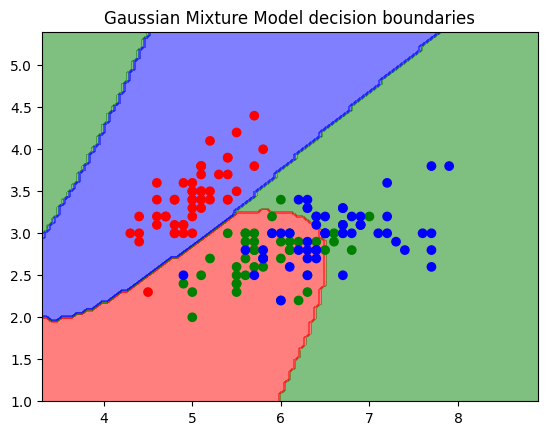

In [28]:
# Assuming we fitted a Gaussian Mixture Model called gmm with a predict method,
# plot which area is assigned to which cluster
disp = DecisionBoundaryDisplay.from_estimator(
    gmm, X_iris_2d,
    response_method="predict",
    # cmap=plt.cm.coolwarm,
    cmap=colormap,
    alpha=0.5
)
plt.scatter(X_iris_2d[:, 0], X_iris_2d[:, 1], c=y_iris, cmap=colormap)
plt.title("Gaussian Mixture Model decision boundaries")
plt.show()

Notice that although the areas predicted for each cluster seem reasonable, the colors do not necessarily match: this is because GMM is an <ins>**unsupervised**</ins> model: we did not provide any label to the model, so it has no way of knowing which cluster corresponds to which label.

**Do the same with K-Means, and compare result. What is the most striking difference?**

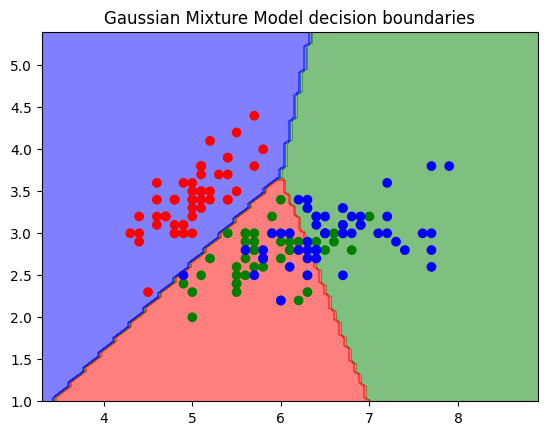

In [29]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_iris_2d)
disp = DecisionBoundaryDisplay.from_estimator(
    kmeans, X_iris_2d,
    response_method="predict",
    # cmap=plt.cm.coolwarm,
    cmap=colormap,
    alpha=0.5
)
plt.scatter(X_iris_2d[:, 0], X_iris_2d[:, 1], c=y_iris, cmap=colormap)
plt.title("Gaussian Mixture Model decision boundaries")
plt.show()

## Mixture's likelihood

Another cool feature of GMM: we have "soft" cluster assignments, which provide an estimate of how certain we are that a point belongs to a cluster.

Let us visualize the probabilities that each point belongs to each cluster with colors.

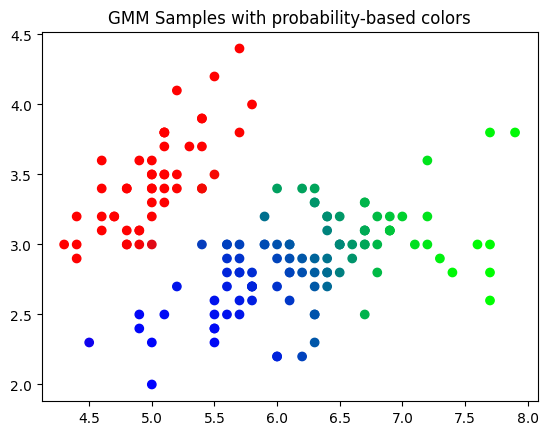

In [30]:
# Get probabilities for each cluster
N, D = X_iris_2d.shape
probs = gmm.predict_proba(X_iris_2d)

# Create RGB colors based on probabilities
# Based on the color displayed on my fit,
# let's use red for cluster 2, green for cluster 1, and for blue cluster 0 to match the initial colors.
# Which color corresponds to which cluster may be easily changed depending on which of your cluster corresponds to which initial color.
colors = np.zeros((N, 3))
colors[:, 0] = probs[:, 2]  # Red channel (cluster 2)
colors[:, 1] = probs[:, 1]  # Green channel (cluster 1)
colors[:, 2] = probs[:, 0]  # Blue channel (cluster 0)

# Plot the first two dimensions with the mixed colors
# plt.figure(figsize=(4,4))
plt.scatter(X_iris_2d[:, 0], X_iris_2d[:, 1], c=colors)
plt.title("GMM Samples with probability-based colors")
plt.show()

Assuming we didn't have access to labels, now we can see that for points in bright red, we are fairly certain that they belong to cluster 2. For some points in green and blue, respectively the leftmost and rightmost points, we are fairly certain they belong to clusters 1 and 0. And for other points, those in the center, we are unsure whether they belong to cluster 1 (green) or 0 (blue).

Let us try to get a better understanding of what is going on. Scikit-learn lets use estimate the (log)likelihood of a point with respect to the distribution of the mixture model: points with high likelihood "fit" the model quite well and are likely to come from this distribution, while points with low likelihood do not seem to fit the data and may be outliers.

**Compute the (log)likelihood with respect to the distribution of the GMM for all points in the dataset**

Hint: similarly to the cluster assigments, you do not need to write the equations yourself: there is a method that does this.

In [42]:
log_likelihoods = gmm.score_samples(X_iris_2d)
print(len(log_likelihoods))

150


**Which 10 points can be considered to be the best representatives of this dataset w.r.t. our model? Which 10 are the least representatives?**

-5.512933029990991 -0.45279018982603075
150
[63 97 73 71 40 43  0 17 26  7]
[131 117 118  41  15  60  68 122 119  62]


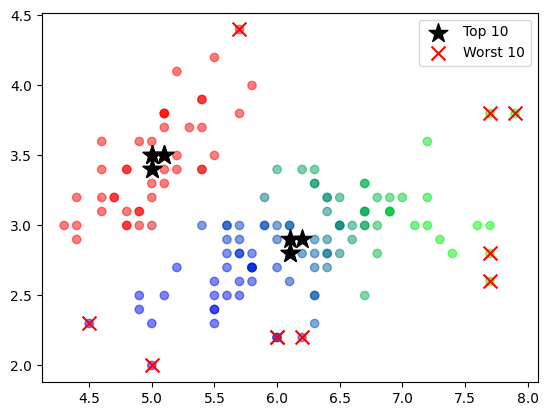

In [49]:
print(np.min(log_likelihoods), np.max(log_likelihoods))
sorted_idx = np.argsort(log_likelihoods)
print(len(sorted_idx))

top10_idx = sorted_idx[-10:]
print(top10_idx)

worst10_idx = sorted_idx[:10]
print(worst10_idx)

plt.scatter(X_iris_2d[:, 0], X_iris_2d[:, 1], c=colors, alpha=0.5)
plt.scatter(X_iris_2d[top10_idx, 0], X_iris_2d[top10_idx, 1], color='black', marker='*', s=200, label='Top 10')
plt.scatter(X_iris_2d[worst10_idx, 0], X_iris_2d[worst10_idx, 1], color='red', marker='x', s=100, label='Worst 10')
plt.legend()
plt.show()

Now, we would like to have more information about which areas correspond to high likelihood versus low likelihood according to the mixture model. For that, we can compute the likelihood associated with each point in our 2D space.

This is very similar to what we did in Lab 4 to obtain probability heatmaps: for a given classifer, we computed the estimated probability associated with each pixel (or with each very small area) of our 2D space. But there is no function like DecisionBoundaryDisplay.from_estimator for this specific use case*, so we will have to do this a bit more manually.

**(as of September 2024 and to the best of my knowledge)*

The function below will take as input a predictor.
The predictor itself takes a 2D input and outputs a value (for example a likelihood, a probability...)
This value is then computed for "every" point in the 2D rectangle from (xmin,ymin) to (xmax,ymax), and the result is returned as an array of shape (50,50), along with the 50x50 corresponding x and y coordinates.

In [ ]:
from typing import Callable

def map_space(predictor: Callable[[np.ndarray], np.ndarray], xmin=4, xmax=8, ymin=1, ymax=5) -> np.ndarray:
    """
    Apply a function f to all points in space in the indicated area

    Args:
        predictor: function taking 2D features (as an numpy array of shape (N,2)) as input,
                   and returning 1 output per input (as an numpy array of shape (N,))
        xmin, xmax etc: define the area to be considered (by default, area of interest for first 2 dimensions of Iris dataset)

    Return:
        XX: all x coordinates, as an array of shape (50,50)
        YY: all y coordinates, as an array of shape (50,50)
        ZZ: predicted values from all the x y, as an array of shape (50,50)
    """
    N_points = 50
    x_range = np.linspace(xmin, xmax, num=N_points) # 50 points from ymin to ymax, shape (50,)
    y_range = np.linspace(ymin, ymax, num=N_points) # 50 points from ymin to ymax, shape (50,)
    XX, YY = np.meshgrid(x_range, y_range) # grids of all x coordinates with all y coordinates, shape (50,50)
    grid = np.array([XX.ravel(), YY.ravel()]).T # all 50 * 50 points arranged in shape (2500,2)
    Z = predictor(grid) # apply f to all point to get 1 value for each point, shape (2500,)
    ZZ = Z.reshape(XX.shape) # rearrange points in a 2D, shape (50,50)
    return XX, YY, ZZ

For instance, here we compute the log-likelihood for every point in the rectangle defined by xmin xmax etc:

In [51]:
# Get the generic log_likelihood
xx, yy, zz = map_space(gmm.score_samples)

These values can then be used to e.g. plot decision contour

In [52]:
from matplotlib.colors import LogNorm, SymLogNorm

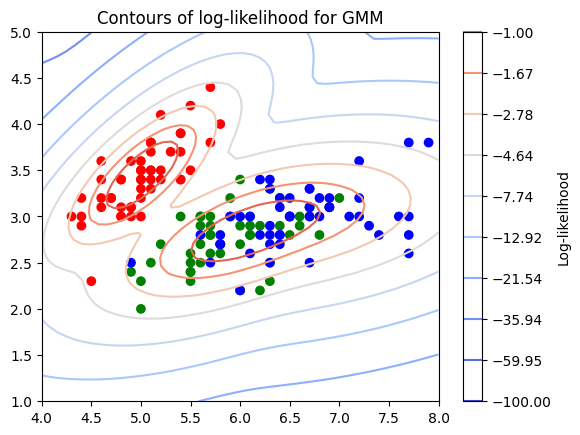

In [53]:
# plt.figure(figsize=(4,4))
# Show contour plot
contour = plt.contour(
    xx, yy, zz,
    # line below is not necessary, but is added so that contours shown better match our scale
    levels=-np.logspace(0,2,10)[::-1], norm=SymLogNorm(linthresh=3, linscale=1, vmin=-100, vmax=0),
    cmap=plt.cm.coolwarm
)
# Add points
plt.scatter(X_iris_2d[:, 0], X_iris_2d[:, 1], c=y_iris, cmap=colormap)
# Add legend, title etc
cbar = plt.colorbar(contour)
cbar.set_label('Log-likelihood')# Label for the color bar
plt.title("Contours of log-likelihood for GMM")
plt.show()

Two of the clusters (green and blue) are quite close to each other: their contour are hard to distinguish if we only look at the total likelihoods of the GMM.

## Cluster's likelihood

We would rather like contours corresponding to the likelihoods of individual clusters.. Unfortunately, there is no easy way to do that with scikit-learn: Scikit-learn implementation only provides the likelihoods/contours for the mixture of gaussians, but not for individual clusters/gaussians. We will need to estimate that ourselves.

**Write a function that takes as inputs a set of points X, the mean mu of a (multivariate) gaussian and the corresponding covariance matrix sigma, and outputs the likelihoods for all points.**

In [57]:
def log_likelihood(X: np.ndarray, mu: np.ndarray, Sigma: np.ndarray) -> np.ndarray:
    """
    Compute the 
    
    Args:
        X: samples for which to compute log-likelihood, shape (N,D)
        mu: mean of Gaussian, shape (D,)
        Sigma: covariance matrix of Gaussian, shape (D,D)

    Return:
        log_likelihoods, shape (N,)
    """
    N, D = X.shape
    log_likelihoods = np.zeros(N)
    
    det_Sigma = np.linalg.det(Sigma)
    inv_Sigma = np.linalg.inv(Sigma)
    
    for i in range(N):
        x_minus_mu = X[i] - mu  # (D,)
        last_term = x_minus_mu.T @ inv_Sigma @ x_minus_mu  # (x-mu)^T Sigma^-1 (x-mu)
        log_likelihoods[i] = -0.5 * (D * np.log(2 * np.pi) + np.log(det_Sigma) + last_term)
    
    return log_likelihoods

**Use this to plot the (log)likelihood contours for cluster 0.**

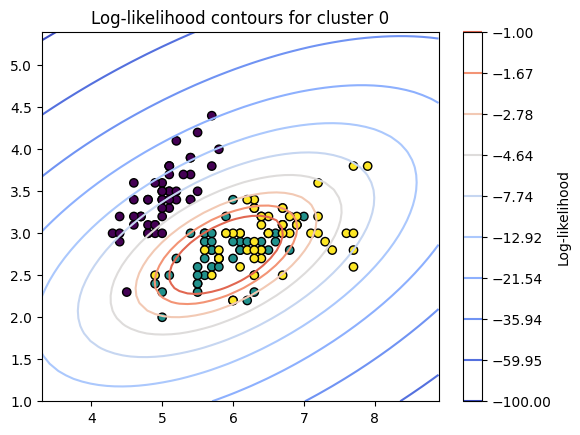

In [58]:
# Cluster 0
mu = gmm.means_[0][:2]
Sigma = gmm.covariances_[0][:2, :2]

# Define predictor function
predictor = lambda X: log_likelihood(X, mu, Sigma)

# Compute values on the grid
xx, yy, zz = map_space(predictor, xmin=X_iris_2d[:,0].min()-1, xmax=X_iris_2d[:,0].max()+1,
                                     ymin=X_iris_2d[:,1].min()-1, ymax=X_iris_2d[:,1].max()+1)

# Plot contours
from matplotlib.colors import SymLogNorm
contour = plt.contour(
    xx, yy, zz,
    levels=-np.logspace(0,2,10)[::-1],
    norm=SymLogNorm(linthresh=3, linscale=1, vmin=-100, vmax=0),
    cmap=plt.cm.coolwarm
)
plt.scatter(X_iris_2d[:, 0], X_iris_2d[:, 1], c=y_iris, cmap='viridis', edgecolor='k')
cbar = plt.colorbar(contour)
cbar.set_label('Log-likelihood')
plt.title("Log-likelihood contours for cluster 0")
plt.show()


**Now do the same thing for all 3 clusters**

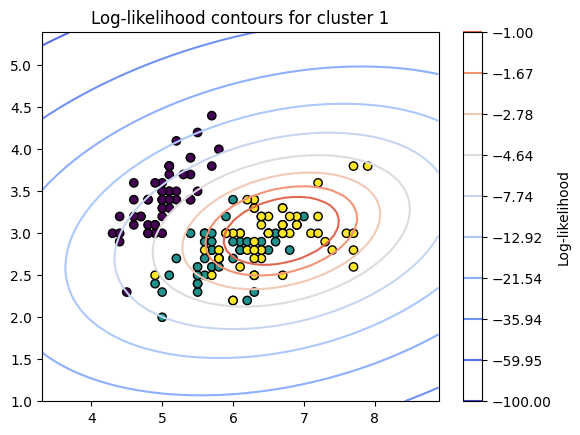

In [ ]:
# Cluster 1
mu = gmm.means_[1][:2]
Sigma = gmm.covariances_[1][:2, :2]


predictor = lambda X: log_likelihood(X, mu, Sigma)

xx, yy, zz = map_space(predictor, xmin=X_iris_2d[:,0].min()-1, xmax=X_iris_2d[:,0].max()+1,
                                     ymin=X_iris_2d[:,1].min()-1, ymax=X_iris_2d[:,1].max()+1)


from matplotlib.colors import SymLogNorm
contour = plt.contour(
    xx, yy, zz,
    levels=-np.logspace(0,2,10)[::-1],
    norm=SymLogNorm(linthresh=3, linscale=1, vmin=-100, vmax=0),
    cmap=plt.cm.coolwarm
)
plt.scatter(X_iris_2d[:, 0], X_iris_2d[:, 1], c=y_iris, cmap='viridis', edgecolor='k')
cbar = plt.colorbar(contour)
cbar.set_label('Log-likelihood')
plt.title("Log-likelihood contours for cluster 1")
plt.show()


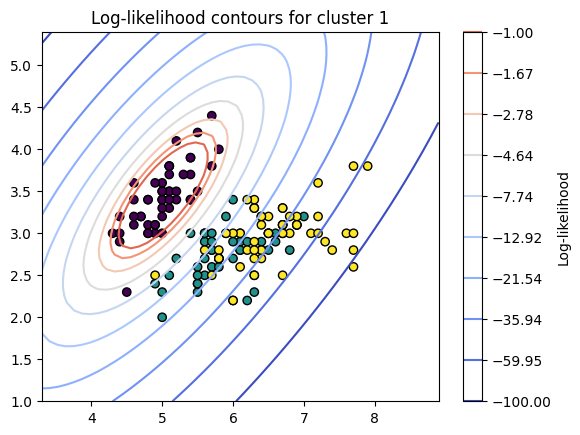

In [60]:
# Cluster 2
mu = gmm.means_[2][:2]
Sigma = gmm.covariances_[2][:2, :2]


predictor = lambda X: log_likelihood(X, mu, Sigma)


xx, yy, zz = map_space(predictor, xmin=X_iris_2d[:,0].min()-1, xmax=X_iris_2d[:,0].max()+1,
                                     ymin=X_iris_2d[:,1].min()-1, ymax=X_iris_2d[:,1].max()+1)


from matplotlib.colors import SymLogNorm
contour = plt.contour(
    xx, yy, zz,
    levels=-np.logspace(0,2,10)[::-1],
    norm=SymLogNorm(linthresh=3, linscale=1, vmin=-100, vmax=0),
    cmap=plt.cm.coolwarm
)
plt.scatter(X_iris_2d[:, 0], X_iris_2d[:, 1], c=y_iris, cmap='viridis', edgecolor='k')
cbar = plt.colorbar(contour)
cbar.set_label('Log-likelihood')
plt.title("Log-likelihood contours for cluster 1")
plt.show()

Recall that the log likelihood of the full Gaussian mixture model can be obtained by a weighted combination of the likelihoods of each individual cluster/Gaussian:

$$
\log p(\mathbf{X}|\boldsymbol{\pi}, \mathbf{M}, \boldsymbol{S}) = \sum_{n=1}^N \log \left(\sum_{k=1}^K \pi_k\mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)\right) 
$$

**Compute the (log) likelihood for the full GMM model for every point in the dataset using the log likelihood of the each cluster. Check that this corresponds to the (log) likelihood returned by scikit-learn**

In [62]:
import numpy as np

N = X_iris.shape[0]
K = gmm.n_components

log_lik_gmm_manual = np.zeros(N)

for n in range(N):
    x_n = X_iris[n:n+1]  # shape (1,4)
    
    cluster_likelihoods = np.zeros(K)
    for k in range(K):
        mu_k = gmm.means_[k]           # (4,)
        Sigma_k = gmm.covariances_[k]  # (4,4)
        pi_k = gmm.weights_[k]
        
        # log-likelihood pour ce cluster (4D)
        log_p = log_likelihood(x_n, mu_k, Sigma_k)[0]
        cluster_likelihoods[k] = pi_k * np.exp(log_p)
    
    log_lik_gmm_manual[n] = np.log(np.sum(cluster_likelihoods))

# Vérification avec scikit-learn
log_lik_sklearn = gmm.score_samples(X_iris)

print("Différence max :", np.max(np.abs(log_lik_gmm_manual - log_lik_sklearn)))
print("Différence moyenne :", np.mean(np.abs(log_lik_gmm_manual - log_lik_sklearn)))


ValueError: operands could not be broadcast together with shapes (4,) (2,) 

## Diagonal covariance matrices

If we wanted to have a result closer to K-Means, where "distances" to cluster centers do not change depending on directions, we could try to fit isotropic Gaussians, i.e. multivariate Gaussians with a covariance matrix

$$
\boldsymbol{\Sigma} = \begin{pmatrix}
\sigma^2 & \dots & 0 \\
\vdots & \ddots & \vdots \\
0 & \dots & \sigma^2
\end{pmatrix}
= \sigma^2 \mathbf{I}
$$

As a result, we should end up with likelihood contours in the shape of circles, instead of ellipsoids as in our previous fit.

**Fit a GMM with isotropic Gaussians, and plot the contours**

Hint: again, there may be an option to do that in scikit-learn.

**Compare decision boundary with KMeans. Would it be possible to obtain similar decision boundaries with a Gaussian Mixture Model? If yes, how?**

Only answer what should be done "in theory", you do not need to do it in practice. If you really insist on doing this question in practice (and again, you do **not** need to do that to answer the question), you should have a look at the "precisions_cholesky_" attribute, which is used in the "predict" method of the GMM.

## 4D GMM

Now let us consider the 4D initial dataset again.

**Fit a GMM similarly to the first question**

**Show the result, and display the probabilistic assignments of each sample using colors**

(plot only the first 2 dimensions)

**Is there any difference with the probabilities fitted with 2 dimensions only? Why?**

Since we know (an estimation of) the distribution of the data, we can also use it to generate/sample new data points.

**Generate some new points, and plot the result. Does it look consistent?**

(plot only the first 2 dimensions)